<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis/blob/main/BulkAnalyze_powerspectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Image

def get_normalized_power_spectrum(signal):
  ps = np.square(np.abs(scipy.fft.rfft(signal)))
  #normalize to sum to 1
  return ps/np.sum(ps)

def get_smoothed_arr(arr, windowsize):
  arr_cumsum = np.array([0] + list(np.cumsum(arr)))
  smooth_arr = arr_cumsum[windowsize:] - arr_cumsum[:-windowsize]
  return smooth_arr

def perform_powerspectrum_analysis(prefix, csm1, num_permutations, freqsmoothwindow):

  freqs = np.fft.rfftfreq(len(csm1), 1)
  nps = get_normalized_power_spectrum(csm1)

  #permute the test data sequence num_permutations times to get an empirical null
  rng = np.random.RandomState(1234)
  nps_permute_2darr = np.array([get_normalized_power_spectrum(rng.permutation(csm1))
                                  for i in range(num_permutations)])

  #smooth the normalized power spectrum. Smoothing window depends on the
  # step size between frequencies
  freq_stepsize = freqs[1]
  #figure out how many steps fit in freqsmoothwindow, round down
  windowsize = int(freqsmoothwindow/freq_stepsize)
  #now smooth
  smooth_nps = get_smoothed_arr(nps, windowsize)
  smooth_nps_permute_2darr = np.array([ get_smoothed_arr(x,windowsize)
                                        for x in nps_permute_2darr ])

  smooth_xaxis = np.linspace(freqsmoothwindow, max(freqs)-freqsmoothwindow, num=len(smooth_nps))

  matplotlib.use('agg') #needed to prevent mem leak sigh
  fig = plt.figure(figsize=(10,2))
  plt.plot(smooth_xaxis, smooth_nps)
  for smooth_nps_permute in smooth_nps_permute_2darr:
    plt.plot(smooth_xaxis, smooth_nps_permute, color="orange", alpha=5.0/num_permutations)
  fig.savefig("/content/drive/MyDrive/GCP_data/analysis/"+prefix+'_nperm'
              +str(num_permutations)+'_smoothnps.png')
  plt.close(fig)
  plt.clf()

  uniform_expectation = 1.0/len(nps)

  #plt.figure(figsize=(10,2))
  #plt.plot(freqs, np.cumsum(nps - uniform_expectation))
  #for nps_permute in nps_permute_2darr:
  #  plt.plot(freqs, np.cumsum(nps_permute - uniform_expectation), color="orange", alpha=0.05)
  #plt.show()

  expected_freq = np.sum(freqs*nps)
  expected_freq_permute_arr = np.sum(freqs[None,:]*nps_permute_2darr, axis=1)

  percentile_ef = np.sum(expected_freq_permute_arr <= expected_freq)/len(expected_freq_permute_arr)

  max_snps = np.max(smooth_nps)
  max_snps_permute_arr = np.max(smooth_nps_permute_2darr, axis=1)
  pvalue_max_snps = np.sum(max_snps_permute_arr >= max_snps)/len(max_snps_permute_arr)

  audc = np.sum(np.abs(np.cumsum(nps - uniform_expectation)))
  audc_permute_arr = np.sum(np.abs(np.cumsum(nps_permute_2darr - uniform_expectation, axis=1)), axis=1);
  pvalue_audc = np.sum(audc_permute_arr >= audc)/len(audc_permute_arr)

  return percentile_ef, pvalue_audc, pvalue_max_snps, (freqs, nps)


In [3]:
def get_chisquareminus1(egg_values):
  #print("Num nan:", np.sum(np.isnan(egg_values)))
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)
  #print("Num nan post mask:", np.sum(np.isnan(egg_values)))

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  #If any rows are all-nan, aboort as if we dropped that row it would mess
  # up the temporal spacing
  #assert (np.sum(num_nonnan_eggs==0)==0), np.sum(num_nonnan_eggs==0)

  sum_eggs = np.nansum(egg_values, axis=1) #get the sum across all eggs - NaNs are automatically skipped
  z_sum_eggs = (sum_eggs - num_nonnan_eggs*100)/np.sqrt(num_nonnan_eggs*200*0.25) #get z scores as per a binomial dist

  return np.square(z_sum_eggs)-1, z_sum_eggs

In [4]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import json

%cd /content/drive/MyDrive/GCP_data

event_to_sumcsm1pval = json.load(open("event_to_sumcsm1pval.json"))

events_sorted_by_pval = sorted(event_to_sumcsm1pval.items(), key=lambda x: x[1])

for (event, pval) in events_sorted_by_pval[:100]:
  metadata = json.load(open("extracted/"+event+"_metadata.json"))
  event_name = metadata["Name"]
  print(event,event_name, pval)

/content/drive/MyDrive/GCP_data
Event391 Internat Day Peace 0.0008192443394802185
Event289 Meditations Valentines Day 0.002569859448349643
Event487 September 21 0.003153268038066148
Event217 Indonesian Earthquake 0.0032705236405630167
Event203 Baghdad Bridge Stampede 0.007938503795130725
Event472 Mandela Dies 0.008229306940944703
Event360 Brazilian Mudslides 0.012434298335079697
Event266 Obama Wins Nomination 0.014699315651582556
Event395 Steve Jobs Dies 0.015513261511045151
Event341 Chilean Miners Alive 0.0159787032720784
Event199 Oraworld Resonance 0.016077254762331683
Event437 Dr. Tomorrow Passes 0.01899878662499621
Event413 Mogadishu Bombing 0.01933102456739566
Event56 Pierre Trudeau Funeral 0.021572192676071245
Event205 Bali Bombing 2 0.022006592782255807
Event324 Health Care is Law 0.02369816101463118
Event272 Palin Acceptance 080903 0.023929771799067412
Event197 Pope Paul's Funeral 0.02405880370764557
Event183 Russian School Hostage Crisis 0.02484189157168082
Event198 Prince Cha

In [29]:
%matplotlib inline

import glob
import json
import numpy as np
import scipy
from matplotlib import pyplot as plt

%cd /content/drive/MyDrive/GCP_data

NUM_PERMUTATIONS = 300
FREQSMOOTH = 0.05

def get_meta_pval(pvals):
  minpval = 1.0/NUM_PERMUTATIONS
  pvals = np.maximum(np.array(pvals), minpval)
  chisquare_stat = -2*np.sum(np.log(pvals))
  deg_freedom = 2*len(pvals)
  return (1 - scipy.stats.chi2.cdf(chisquare_stat, df=deg_freedom))

percentiles_ef = {"test": [], "control1": [], "control2": []}
pvals_audc = {"test": [], "control1": [], "control2": []}
pvals_maxp = {"test": [], "control1": [], "control2": []}
ps_tuples = {"test": [], "control1": [], "control2": []}

event_count = 0

for (event, pval) in events_sorted_by_pval[:100]:
  metadata = json.load(open("extracted/"+event+"_metadata.json"))
  event_name = metadata["Name"]

  event_count += 1
  print("\n--------------------------------")
  print("Event Count:",event_count,event,event_name,pval)

  for spanname in ['test', 'control1', 'control2']:
    print("span:", spanname)
    egg_values = np.load("extracted/"+event+"_"+spanname+"_eggvalues.npy")

    csm1, z_sum_eggs = get_chisquareminus1(egg_values)
    #plot csm1 vals for context
    #%matplotlib inline
    #plt.figure(figsize=(10,2))
    #plt.plot(np.cumsum(csm1))
    #plt.show()

    (percentile_ef, pval_audc, pval_maxp, ps_tuple) = (
        perform_powerspectrum_analysis(event+"_"+spanname, csm1, NUM_PERMUTATIONS, FREQSMOOTH))
    print(spanname,"ef percentile", percentile_ef)
    print(spanname,"audc pval", pval_audc)
    print(spanname,"maxd pval", pval_maxp)
    percentiles_ef[spanname].append(percentile_ef)
    pvals_audc[spanname].append(pval_audc)
    pvals_maxp[spanname].append(pval_maxp)
    ps_tuples[spanname].append(ps_tuple)
    #print(spanname,"ef meta pval:", get_meta_pval(1-np.array(percentiles_ef[spanname])))
    #print(spanname,"audc meta pval:", get_meta_pval(pvals_audc[spanname]))
    #print(spanname,"maxp meta pval:", get_meta_pval(pvals_maxp[spanname]))



/content/drive/MyDrive/GCP_data

--------------------------------
Event Count: 1 Event391 Internat Day Peace 0.0008192443394802185
span: test
test ef percentile 0.35
test audc pval 0.6933333333333334
test maxd pval 0.32666666666666666
span: control1
control1 ef percentile 0.06666666666666667
control1 audc pval 0.1
control1 maxd pval 0.31
span: control2
control2 ef percentile 0.5966666666666667
control2 audc pval 0.9233333333333333
control2 maxd pval 0.7266666666666667

--------------------------------
Event Count: 2 Event289 Meditations Valentines Day 0.002569859448349643
span: test
test ef percentile 0.9966666666666667
test audc pval 0.02
test maxd pval 0.056666666666666664
span: control1
control1 ef percentile 0.11333333333333333
control1 audc pval 0.29333333333333333
control1 maxd pval 0.56
span: control2
control2 ef percentile 0.35
control2 audc pval 0.86
control2 maxd pval 0.5533333333333333

--------------------------------
Event Count: 3 Event487 September 21 0.00315326803806614

In [30]:
import json

prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_"

#save the pvals
open(prefix+"percentilesef.json","w").write(json.dumps(percentiles_ef, indent=4))
open(prefix+"pvalsaudc.json","w").write(json.dumps(pvals_audc, indent=4))
open(prefix+"pvalsmaxp.json","w").write(json.dumps(pvals_maxp, indent=4))

7133

<Figure size 640x480 with 0 Axes>

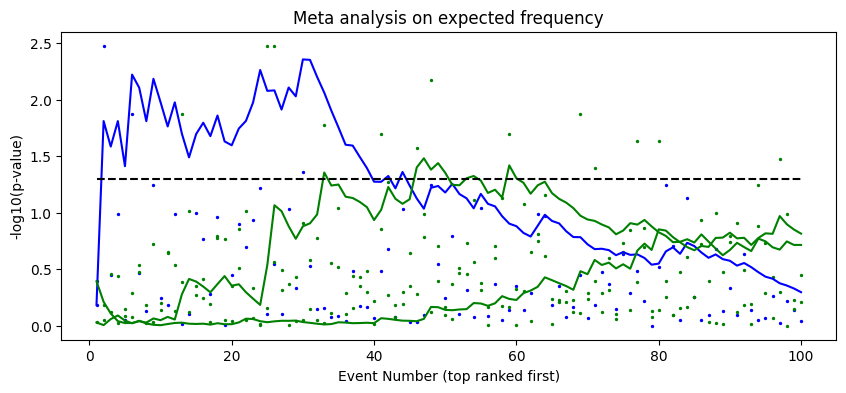

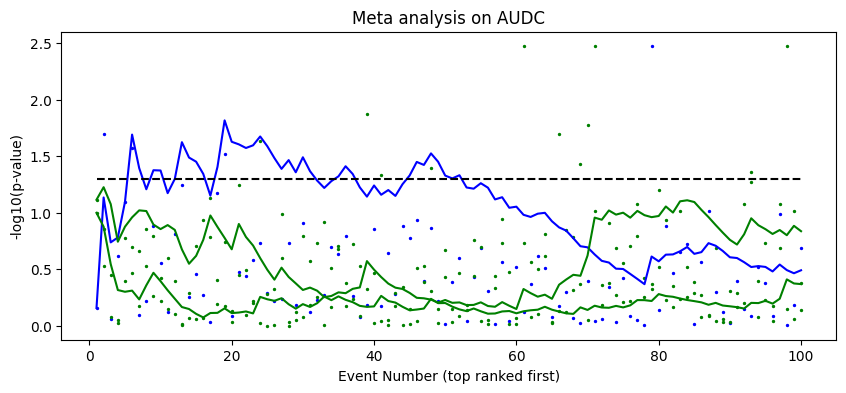

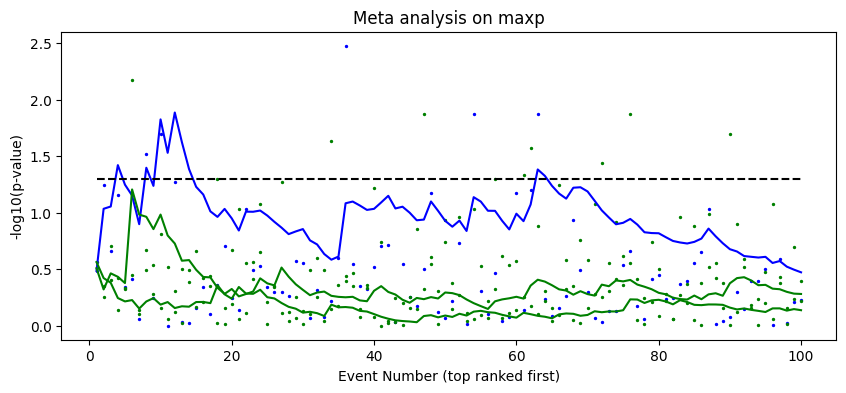

In [31]:
#plot how the meta pvalue changes with samples

def get_iterative_metapvals(pvals):
 return np.array([(get_meta_pval(pvals[:i+1])) for i in range(len(pvals))])

min_meta = 1 # start the x axis here
max_meta = len(percentiles_ef["test"]) #where to stop the plot

def make_meta_trend_plot(title, test_pvals, control1_pvals, control2_pvals):
  %matplotlib inline
  fig = plt.figure(figsize=(10,4))
  xaxis = list(range(min_meta,max_meta+1))

  #floor p values at the lowest detectable
  test_pvals, control1_pvals, control2_pvals = [
      np.maximum(arr, 1.0/NUM_PERMUTATIONS) for arr in
       [test_pvals, control1_pvals, control2_pvals]]

  test_metapvals = -np.log10(get_iterative_metapvals(test_pvals))
  control1_metapvals = -np.log10(get_iterative_metapvals(control1_pvals))
  control2_metapvals = -np.log10(get_iterative_metapvals(control2_pvals))

  theslice = slice(min_meta-1, max_meta)

  handles = []

  handles.append(plt.scatter(xaxis, -np.log10(test_pvals[theslice]), color="blue", s=2))
  handles.append(plt.scatter(xaxis, -np.log10(control1_pvals[theslice]), color="green", s=2))
  plt.scatter(xaxis, -np.log10(control2_pvals[theslice]), color="green", s=2)

  handles.append(plt.plot(xaxis, test_metapvals[theslice], color="blue"))
  handles.append(plt.plot(xaxis, control1_metapvals[theslice], color="green"))
  plt.plot(xaxis, control2_metapvals[theslice], color="green")

  plt.plot([min(xaxis), max(xaxis)], [-np.log10(0.05), -np.log10(0.05)],
           color="black", linestyle="--")

  plt.xlabel("Event Number (top ranked first)")
  plt.ylabel("-log10(p-value)")
  plt.title(title)
  plt.show()

make_meta_trend_plot("Meta analysis on expected frequency",
                     test_pvals=1-np.array(percentiles_ef["test"]),
                     control1_pvals=1-np.array(percentiles_ef["control1"]),
                     control2_pvals=1-np.array(percentiles_ef["control2"]))

make_meta_trend_plot("Meta analysis on AUDC",
                     test_pvals=np.array(pvals_audc["test"]),
                     control1_pvals=np.array(pvals_audc["control1"]),
                     control2_pvals=1-np.array(pvals_audc["control2"]))

make_meta_trend_plot("Meta analysis on maxp",
                     test_pvals=np.array(pvals_maxp["test"]),
                     control1_pvals=np.array(pvals_maxp["control1"]),
                     control2_pvals=1-np.array(pvals_maxp["control2"]))